In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pettingzoo.mpe import simple_speaker_listener_v4

def make_env():
    env = simple_speaker_listener_v4.parallel_env(continuous_actions=False, render_mode="rgb_array", max_cycles=25)
    env.reset()
    return env

def make_env_human():
    env = simple_speaker_listener_v4.parallel_env(continuous_actions=False, render_mode="human", max_cycles=25)
    env.reset()
    return env

# Test the environment
env = make_env()
print("Agents:", env.agents)  # ['speaker_0', 'listener_0']

Agents: ['speaker_0', 'listener_0']


## Plotting functions

## Expert Demonstrations
For simplicity, we use a heuristic expert where:

Speaker broadcasts the target landmark color.

Listener moves toward the target landmark.

Expert PPO

In [ ]:
env = simple_speaker_listener_v4.parallel_env(max_cycles=25, continuous_actions=False)
env = parallel_to_aec(env)

Expert Old

In [3]:
def expert_policy(obs, is_expert):
    actions = {}
    for agent in obs.keys():
        if "speaker" in agent:
            # Speaker: Broadcast target color
            target_color = np.argmax(obs[agent][-3:])
            actions[agent] = target_color
        else:
            # Listener: Use RELATIVE position from observation
            # Get the target color from the communication part of its own observation
            comm = obs[agent][-3:]  # assuming comm is the last 3 elements
            target_color = np.argmax(comm)
            # Extract relative position of the target landmark
            # Observation format: [self_vel (2), landmark0_rel (2), landmark1_rel (2), landmark2_rel (2), comm (3)]
            rel_x = obs[agent][2 + 2 * target_color]
            rel_y = obs[agent][2 + 2 * target_color + 1]
            # Decide action based on relative position
            if abs(rel_x) > abs(rel_y):
                actions[agent] = 2 if rel_x > 0 else 1  # Right/Left
            else:
                actions[agent] = 4 if rel_y > 0 else 3  # Up/Down
    return actions

In [ ]:
def generate_expert_data(num_episodes=50):
    env = make_env()
    expert_data = {agent: {"states": [], "actions": []} for agent in env.agents}

    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False

        while not done:
            # Use the expert_policy to generate actions
            actions = expert_policy(obs, is_expert=True)

            # Record data for both agents
            for agent in env.agents:
                expert_data[agent]["states"].append(obs[agent])
                expert_data[agent]["actions"].append(actions[agent])

            obs, _, done, _, _ = env.step(actions)
    
    env.close()
    return expert_data

generate_expert_data(num_episodes=50)

In [5]:
import matplotlib.pyplot as plt

def evaluate_policy(policy_fn, num_episodes=100, is_expert=False):
    env = make_env()
    success_rates = []
    avg_rewards = []
    avg_steps = []
    
    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        steps = 0
        listener_positions = []
        target_pos = None
        
        while not done:
            actions = policy_fn(obs, is_expert)
            obs, rewards, done, _, _ = env.step(actions)
            
            # Track listener position and target
            if is_expert:
                listener_pos = obs["listener_0"][:2]
                target_pos = np.argmax(obs["speaker_0"][-3:])  # FIXED: Use last 3 values
            else:
                listener_pos = obs["listener_0"][:2]
                target_pos = np.argmax(obs["speaker_0"][-3:])  # Already correct
            
            listener_positions.append(listener_pos)
            total_reward += sum(rewards.values())
            steps += 1
        
        # Check if listener reached target (within 0.2 units)
        target_landmark = env.unwrapped.world.landmarks[target_pos].state.p_pos
        final_dist = np.linalg.norm(listener_positions[-1] - target_landmark)
        success = final_dist < 0.2
        
        success_rates.append(success)
        avg_rewards.append(total_reward)
        avg_steps.append(steps)
    
    return {
        "success_rate": np.mean(success_rates),
        "avg_reward": np.mean(avg_rewards),
        "avg_steps": np.mean(avg_steps)
    }


def learned_policy(obs, _):
    actions = {}
    for agent in obs.keys():
        obs_tensor = torch.FloatTensor(obs[agent])
        action_probs = policies[agent](obs_tensor)
        action = torch.argmax(action_probs).item()
        actions[agent] = action
    return actions

In [19]:
# Generate expert data and validate
expert_data = generate_expert_data(num_episodes=50)
expert_stats = evaluate_policy(expert_policy, num_episodes=20, is_expert=True)
print("Expert Success Rate:", expert_stats['success_rate'])
if expert_stats['success_rate'] < 0.8:
    print("Warning: Expert policy is suboptimal. Consider improving heuristics.")

Expert Success Rate: 0.05


## Define MAGAIL Networks

In [46]:
import torch
import torch.nn as nn

# Policy Networks (one per agent)
class Policy(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.ReLU(),
            nn.Linear(64, act_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.net(x)

# Discriminator Networks (one per agent)
class Discriminator(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid())
    
    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=-1))
    
# Value Network as baseline
class ValueNet(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.net(x)


# Initialize policies and discriminators

speaker_obs_dim = 3     #[goal_id]
listener_obs_dim = 11 #[self_vel, all_landmark_rel_positions, communication]

speaker_act_dim = 3 # [say_0, say_1, say_2, say_3, say_4, say_5, say_6, say_7, say_8, say_9]
listener_act_dim = 5 # [no_action, move_left, move_right, move_down, move_up]

policies = {
    "speaker_0": Policy(obs_dim=speaker_obs_dim, act_dim=speaker_act_dim),  
    "listener_0": Policy(obs_dim=listener_obs_dim, act_dim=listener_act_dim)   
}

# For Discriminator the output is a single value
discriminators = {
    "speaker_0": Discriminator(obs_dim=3, act_dim=3),   # Speaker: 3 obs + 3 actions
    "listener_0": Discriminator(obs_dim=11, act_dim=5)  # Listener: 11 obs + 5 actions
}

# Initialize value networks
value_nets = {
    "speaker_0": ValueNet(obs_dim=speaker_obs_dim),
    "listener_0": ValueNet(obs_dim=listener_obs_dim)
}


## Training MAGAIL

In [47]:
def train_magail(expert_data, num_epochs=1000, batch_size=32):
    # Optimizers
    optimizers = {
        agent: {
            "policy": torch.optim.Adam(policies[agent].parameters(), lr=1e-3),
            "disc": torch.optim.Adam(discriminators[agent].parameters(), lr=1e-3),
            "value": torch.optim.Adam(value_nets[agent].parameters(), lr=1e-3)
        } for agent in ["speaker_0", "listener_0"]
    }
    
    for epoch in range(num_epochs):
        # --- Collect policy trajectories ---
        env = make_env()
        policy_data = {agent: {"states": [], "actions": []} for agent in env.agents}
        obs, _ = env.reset()
        done = False
        
        while not done:
            actions = {}
            for agent in env.agents:
                obs_tensor = torch.FloatTensor(obs[agent])
                action_probs = policies[agent](obs_tensor)
                # Simpling from action distribution - enables exploration during training
                action = torch.multinomial(action_probs, 1).item()
                actions[agent] = action
                policy_data[agent]["states"].append(obs[agent])
                policy_data[agent]["actions"].append(action)
            
            obs, _, done, _, _ = env.step(actions)
        
        # --- Update discriminators ---
        for agent in ["speaker_0", "listener_0"]:
            # Expert data
            expert_states = torch.FloatTensor(expert_data[agent]["states"])
            expert_actions = torch.LongTensor(expert_data[agent]["actions"])
            
            # Policy data
            policy_states = torch.FloatTensor(policy_data[agent]["states"])
            policy_actions = torch.LongTensor(policy_data[agent]["actions"])

             # One-hot encode actions (different for speaker/listener)
            if "speaker" in agent:
                num_classes = 3  # Speaker has 3 actions
            else:
                num_classes = 5  # Listener has 5 actions
            
            expert_actions_onehot = torch.nn.functional.one_hot(expert_actions, num_classes=num_classes).float()
            policy_actions_onehot = torch.nn.functional.one_hot(policy_actions, num_classes=num_classes).float()
            
            # Discriminator loss
            # TODO # Discriminator loss: max[log(D(expert)) + log(1 - D(policy))] => min[-log(D(expert)) - log(1 - D(policy))], 
            # but the formula given by the paper is inversed
            real_loss = -torch.log(discriminators[agent](expert_states, expert_actions_onehot)).mean()
            fake_loss = -torch.log(1 - discriminators[agent](policy_states, policy_actions_onehot)).mean()
            disc_loss = real_loss + fake_loss
            
            optimizers[agent]["disc"].zero_grad()
            disc_loss.backward()
            optimizers[agent]["disc"].step()
        
        # --- Update policies (centralized training) ---
        for agent in ["speaker_0", "listener_0"]:
            states = torch.FloatTensor(policy_data[agent]["states"])
            actions = torch.LongTensor(policy_data[agent]["actions"])
            # One-hot encode actions
            if "speaker" in agent:
                num_classes = 3
            else:
                num_classes = 5
            actions_onehot = torch.nn.functional.one_hot(actions, num_classes=num_classes).float()
            
            # TODO Here we did not use a base line as described in the paper?

            # Adversarial reward: log(D(s,a))
            # It seems to be: D(s,a) How much u think it is from the expert, so we wanna maximize this reward
            # In paper it can be -log(D(s,a)) which outputs the probability that (s,a) from the policy
            with torch.no_grad():
                rewards = torch.log(discriminators[agent](states, actions_onehot))

                # Compute value baseline
                values = value_nets[agent](states)
                # Compute advantages (reward-to-go - baseline)
                advantages = rewards - values.squeeze()

            # Update value network (MSE Loss)
            value_loss = (values.squeeze() - rewards).pow(2).mean()
            # Clear the gradient
            optimizers[agent]["value"].zero_grad()
            value_loss.requires_grad = True
            value_loss.backward()
            optimizers[agent]["value"].step()

            # Policy gradient
            action_probs = policies[agent](states)
            log_probs = torch.log(action_probs.gather(1, actions.unsqueeze(1)))

            # If we didn't call advantage.detach(), the gradients would flow through the advantage tensor, and the value network's parameters would be updated using the policy loss, which is not what we want.
            policy_loss = -(log_probs * advantages.detach()).mean()
            
            optimizers[agent]["policy"].zero_grad()
            policy_loss.backward()
            optimizers[agent]["policy"].step()
        
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch} Disc Loss: {disc_loss.item():.3f}, Policy Loss: {policy_loss.item():.3f}")
            eval_stats = evaluate_policy(learned_policy, num_episodes=20)
            print(f"Epoch {epoch}: Success Rate={eval_stats['success_rate']:.2f}, Avg Reward={eval_stats['avg_reward']:.2f}")

    env.close()
train_magail(expert_data)

Epoch 0 Disc Loss: 1.379, Policy Loss: -1.189
Epoch 0: Success Rate=0.00, Avg Reward=-3.00
Epoch 10 Disc Loss: 1.347, Policy Loss: -1.340
Epoch 10: Success Rate=0.00, Avg Reward=-2.58
Epoch 20 Disc Loss: 1.345, Policy Loss: -1.335
Epoch 20: Success Rate=0.00, Avg Reward=-2.88
Epoch 30 Disc Loss: 1.396, Policy Loss: -1.536
Epoch 30: Success Rate=0.10, Avg Reward=-2.43
Epoch 40 Disc Loss: 1.220, Policy Loss: -1.291
Epoch 40: Success Rate=0.05, Avg Reward=-3.31
Epoch 50 Disc Loss: 1.453, Policy Loss: -1.519
Epoch 50: Success Rate=0.00, Avg Reward=-2.39
Epoch 60 Disc Loss: 1.430, Policy Loss: -0.822
Epoch 60: Success Rate=0.10, Avg Reward=-2.82
Epoch 70 Disc Loss: 1.264, Policy Loss: -1.106
Epoch 70: Success Rate=0.00, Avg Reward=-2.99
Epoch 80 Disc Loss: 1.296, Policy Loss: -0.832
Epoch 80: Success Rate=0.00, Avg Reward=-2.48
Epoch 90 Disc Loss: 1.386, Policy Loss: -0.923
Epoch 90: Success Rate=0.05, Avg Reward=-2.35
Epoch 100 Disc Loss: 1.226, Policy Loss: -1.287
Epoch 100: Success Rate=

## Test the Learned Policy

In [48]:
# Evaluate expert policy
expert_stats = evaluate_policy(expert_policy, num_episodes=100, is_expert=True)

# Evaluate learned policy
learned_stats = evaluate_policy(learned_policy, num_episodes=100)

# (Optional) Evaluate random policy
def random_policy(obs, _):
    return {agent: env.action_space(agent).sample() for agent in obs.keys()}
random_stats = evaluate_policy(random_policy, num_episodes=100)

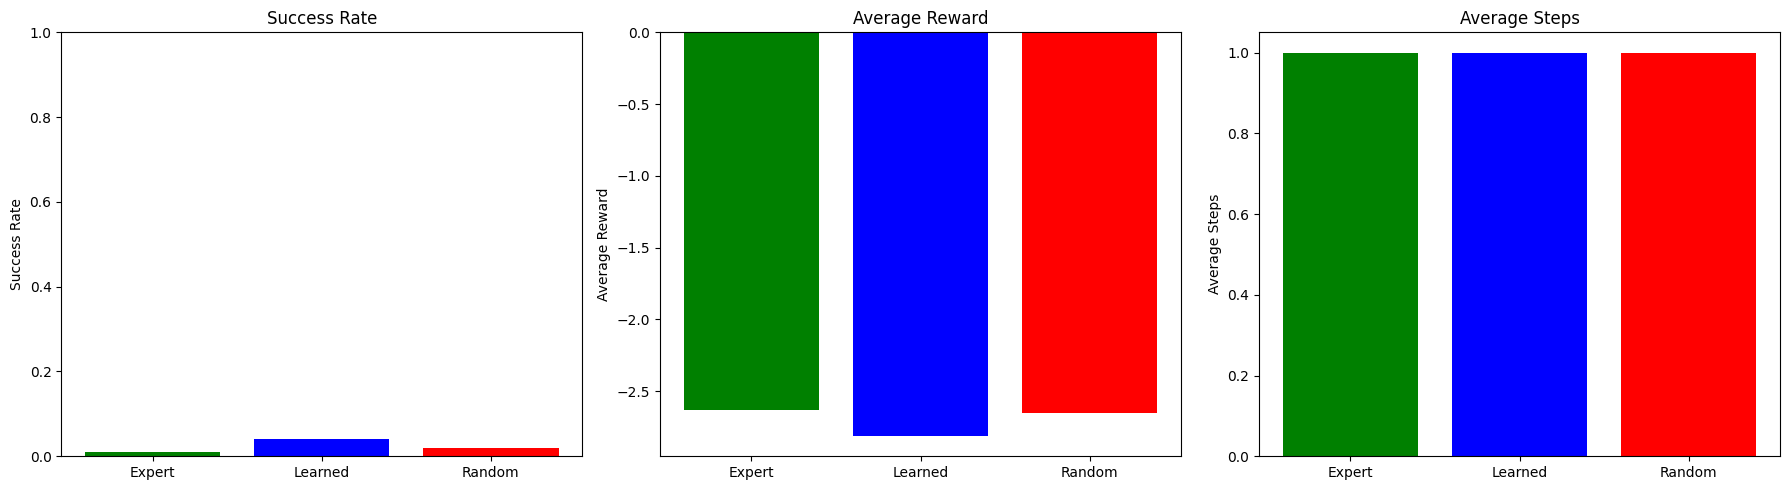

In [50]:
labels = ['Expert', 'Learned', 'Random']
metrics = ['success_rate', 'avg_reward', 'avg_steps']
titles = ['Success Rate', 'Average Reward', 'Average Steps']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    expert_val = expert_stats[metric]
    learned_val = learned_stats[metric]
    random_val = random_stats[metric]
    
    axes[idx].bar(labels, [expert_val, learned_val, random_val], color=['green', 'blue', 'red'])
    axes[idx].set_title(title)
    axes[idx].set_ylabel(title)
    
    if metric == 'success_rate':
        axes[idx].set_ylim(0, 1)

plt.tight_layout()
plt.show()